In [1]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt


In [2]:
def generate_dataset(n_samples, mean1, cov1, mean2, cov2, prior_0):
    dataset=[]
    for i in range(n_samples):
        Y_current = np.random.binomial(n=1, p=prior_0, size=1)      #tossCoin(p)
        if Y_current == 0:
            X_current = np.random.multivariate_normal(mean1, cov1, 1)
        else:
            X_current = np.random.multivariate_normal(mean2, cov2, 1)
        dataset.append([X_current[0][0], X_current[0][1], X_current[0][2], X_current[0][3], X_current[0][4], X_current[0][5], Y_current[0]])
    return dataset

In [3]:
def generate_dataset_class0(n_samples, mean1, cov1):
    return np.random.multivariate_normal(mean1, cov1, n_samples)

In [4]:
def train_test_split(data, train_per):
    
    #Shuffling the data 
    #data = data.sample(frac=1,random_state=1)
    
    # test set and train set 
    train, test = np.split(data,[int(train_per * len(data))])
    
    #Spliting fetures and labels
    X_test, Y_test = np.delete(test,6,1), np.delete(test,[0,1,2,3,4,5],1).flatten()
    X_train, Y_train = np.delete(train,6,1), np.delete(train,[0,1,2,3,4,5],1).flatten()
    
    return X_train,X_test,Y_train,Y_test

In [5]:
class multivariate_NP:

    def re_dim_x(self, x):
        return x[...,np.newaxis] if (x.ndim == 2) else x
    def fit(self,x,y):
        #x= self.re_dim_x(x)
        self.mean_0 = np.average(x[y==0],axis=0)
        self.mean_1 = np.average(x[y==1],axis=0)
        #self.sigma= np.einsum('ijk,ikj->jk',x-self.mean_0,x-self.mean_0) /(x.shape[0]-1)
        self.cov_0 = np.cov( x[y==0],rowvar=False)
        self.cov_1 = np.cov(x[y==1],rowvar=False)

        self.p0 = y[y==0].shape[0]/y.shape[0]
        self.p1 = 1-self.p0
        #print(self.mean_1,self.cov_1)


    def predict(self, X,k):
        y_pred = [self.helper_predict(x,k) for x in X]
        return np.array(y_pred)
    
    def helper_predict(self, x,k):
        data = np.array([x])
        likelihood_0 = multivariate_normal.pdf(data, self.mean_0, self.cov_0)
        likelihood_1 = multivariate_normal.pdf(data, self.mean_1, self.cov_1)
        if likelihood_1/likelihood_0 > k :
            return 1
        else :
            return 0
    
    def estimate_k(self, X, k, alpha):
        lambda_c = self.estimate_lambda(X, k)
        queue=[-1,-1]
        incr=1
        queue.append(lambda_c)
        while abs(lambda_c-alpha)>=0.005:
            if(queue[0] == queue[2] and queue[0] == queue[1]):
                incr*=2
            elif(queue[0] == queue[2] and queue[0] != queue[1]):
                incr /= 2
            #print(lambda_c,k,end=" ")
            if lambda_c < alpha:
                k -= incr
            else:
                k += incr
            lambda_c = self.estimate_lambda(X,k)
            queue.pop(0)
            queue.append(lambda_c)

        #print("current value of alpha approximately for given alpha:", alpha, "is :", lambda_c)
        return k
  
    def estimate_lambda(self, X, k):
        count = 0; i = 0
        for x in X:
            data = np.array([x])
            #print(data.shape)
            fx_0 = multivariate_normal.pdf(data, self.mean_0, self.cov_0)
            fx_1 = multivariate_normal.pdf(data, self.mean_1, self.cov_1)
            if fx_1/fx_0 > k :
                count += 1
        #print(count)
        return count/len(X)

In [6]:
class multivariate_gausian:

    def fit(self,x,y):
        self.mean_0 = np.average(x[y==0], axis=0)
        self.mean_1 = np.average(x[y==1], axis=0)
        self.cov_0 = np.cov( x[y==0], rowvar = False)
        self.cov_1 = np.cov( x[y==1], rowvar = False)
        self.p0 = y[y==0].shape[0] / y.shape[0]
        self.p1 = 1-self.p0
        print(self.mean_1, self.cov_1)

    def predict(self, X):
        
        y_pred = [self.helper_predict(x) for x in X]
        return np.array(y_pred)
    
    def helper_predict(self, x):
        
        data = np.array([x])
        likelihood_0 = multivariate_normal.pdf(data, self.mean_0, self.cov_0)
        likelihood_1 = multivariate_normal.pdf(data, self.mean_1, self.cov_1)
        if likelihood_1*self.p1 > likelihood_0*self.p0  :
            return 1
        else:
            return 0

In [7]:
def accurecy(Y_test, Y_pred):
  f_p,t_n,t_p,f_n,i=0,0,0,0,0
  while i<len(Y_pred):
    if (Y_pred[i] != Y_test[i]):
      if (Y_pred[i]==1):
        f_p += 1
      else:
        f_n += 1
    elif  (Y_pred[i] == Y_test[i]):
      if (Y_pred[i]==1):
        t_p += 1
      else:
        t_n += 1
    i+=1
  accurecy = (t_p + t_n) / len(Y_test)
  return t_n, f_p, f_n, t_p, accurecy*100

In [8]:
#Drive Code
n_samples=10000
prior_0=0.5
prior_1= 1-prior_0

#mean and covariance for class-0
mean1 = np.array([0, 0, 0, 0 , 0, 0])
u=[1,1,1,1,1,1]
cov1 = np.diag(u)
#np.array([[1, 0, 0,0], [0, 1, 0],[0, 0, 1]])  # diagonal covariance

#mean and covariance for class-1
mean2 = np.array([1, 1, 1, 1, 1, 1])
v=[1,2,3,5,2,1]
cov2 = np.diag(v)

#Threshold for type-1 error
alpha_set=np.array([0.01,0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.5,0.8]) 
k=3
k_list=[]
dataset= generate_dataset(n_samples,mean1,cov1,mean2,cov2,prior_0)
#print(dataset)

X_train, X_test, Y_train, Y_test = train_test_split(dataset,0.5)
print(X_train.shape,X_test.shape, Y_test.shape)


dataset_c0 = generate_dataset_class0(n_samples, mean1, cov1)


(5000, 6) (5000, 6) (5000,)


In [9]:
model=multivariate_gausian()
model.fit(X_train,Y_train)
Y_pred =model.predict(X_test)
print("True Positive ,False Positive, accuracy of gausian :",accurecy(Y_test, Y_pred))


[1.04140436 1.01217563 0.96083983 0.98531772 1.02011258 0.97710672] [[ 9.98186954e-01  1.51243889e-02  1.21759462e-02 -3.50557354e-02
  -2.10692571e-02 -9.01185684e-03]
 [ 1.51243889e-02  1.98947916e+00 -9.13578898e-02 -7.74888940e-02
   2.11877124e-02 -6.50788014e-03]
 [ 1.21759462e-02 -9.13578898e-02  3.07074451e+00 -1.56677242e-02
  -4.25635687e-02  4.94547893e-02]
 [-3.50557354e-02 -7.74888940e-02 -1.56677242e-02  5.16720597e+00
  -7.97233437e-02  3.89294915e-02]
 [-2.10692571e-02  2.11877124e-02 -4.25635687e-02 -7.97233437e-02
   2.10737084e+00 -1.76989829e-03]
 [-9.01185684e-03 -6.50788014e-03  4.94547893e-02  3.89294915e-02
  -1.76989829e-03  9.94684311e-01]]
True Positive ,False Positive, accuracy of gausian : (2332, 215, 316, 2137, 89.38000000000001)


In [10]:
model= multivariate_NP()
model.fit(X_train,Y_train)


for alpha in alpha_set:
    k_list.append(model.estimate_k(dataset_c0, k, alpha))
print("K_list for given type1 error threshold", k_list)

true_positive=np.zeros(len(alpha_set))
false_positive=np.zeros(len(alpha_set))
true_negative=np.zeros(len(alpha_set))
false_negative=np.zeros(len(alpha_set))
accuracy=np.zeros(len(alpha_set))

for i in range(len(alpha_set)):
    Y_pred = model.predict(X_test, k_list[i])
    true_negative[i], false_positive[i], false_negative[i], true_positive[i], accuracy[i] = accurecy(Y_test, Y_pred)

#printing fp,tp,accuracy for different threshould alpha
for i in range(len(alpha_set)):
    print("Type 1 error <={}, true_negative : {}, false positives : {}, false_negative :{}, true positives : {}, accuracy : {} %".format(alpha_set[i], true_negative[i], false_positive[i], false_negative[i], true_positive[i], accuracy[i]))




K_list for given type1 error threshold [5, 2.5, 1.5, 1, 0.75, 0.34375, 0.1875, 0.0703125, 0.015625]
Type 1 error <=0.01, true_negative : 2510.0, false positives : 37.0, false_negative :665.0, true positives : 1788.0, accuracy : 85.96000000000001 %
Type 1 error <=0.03, true_negative : 2474.0, false positives : 73.0, false_negative :519.0, true positives : 1934.0, accuracy : 88.16000000000001 %
Type 1 error <=0.05, true_negative : 2420.0, false positives : 127.0, false_negative :409.0, true positives : 2044.0, accuracy : 89.28 %
Type 1 error <=0.08, true_negative : 2343.0, false positives : 204.0, false_negative :326.0, true positives : 2127.0, accuracy : 89.4 %
Type 1 error <=0.1, true_negative : 2280.0, false positives : 267.0, false_negative :276.0, true positives : 2177.0, accuracy : 89.14 %
Type 1 error <=0.2, true_negative : 2049.0, false positives : 498.0, false_negative :163.0, true positives : 2290.0, accuracy : 86.78 %
Type 1 error <=0.3, true_negative : 1812.0, false positives

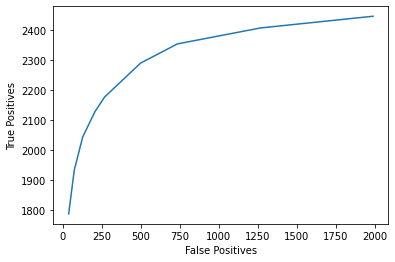

In [11]:
#plotting ROC graph
plt.plot(false_positive,true_positive)
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.show()